In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import config
from src.datasets import TextConcatFactCheck, TextConcatPosts

tasks_path = config.TASKS_PATH
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH
gs_path = config.GS_PATH
lang = 'deu'
task_name = "monolingual"

fc = TextConcatFactCheck(fact_checks_path, tasks_path=tasks_path, task_name=task_name, lang=lang)
posts = TextConcatPosts(posts_path, tasks_path=tasks_path, task_name=task_name, lang=lang, gs_path=gs_path)

In [15]:
df_train_posts = posts.df_train
df_dev_posts = posts.df_dev
df_fc = fc.df

In [16]:
from src.models import EmbeddingModel, CrossencoderModel

teacher_model_path = '/home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb'
teacher_model = EmbeddingModel(model_name=teacher_model_path, df_fc=df_fc, batch_size=512, k=100000)

Batches: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [17]:
df_dev_posts["preds"] = teacher_model.predict(df_dev_posts["full_text"].values).tolist()

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


In [37]:
ls_k = list(range(1, 501))
d_eval = teacher_model.evaluate(df_dev_posts, task_name, lang, ls_k=ls_k, output_folder="tmp/teacher")

<Axes: >

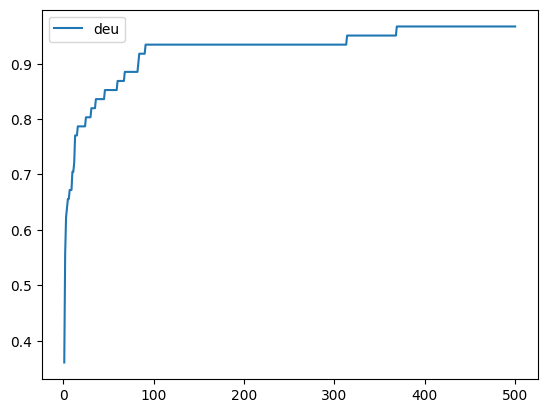

In [19]:
df_metrics = pd.DataFrame(d_eval["monolingual"])
df_metrics.plot()

In [20]:
from src.models import CrossEncoder
reranker_model_name = '/gpfs/projects/bsc14/abecerr1/hub/models--jinaai--jina-reranker-v2-base-multilingual/snapshots/126747772a932960028d9f4dc93bd5d9c4869be4'
rerank_model = CrossEncoder(reranker_model_name, num_labels=1, max_length=1024, trust_remote_code=True)


In [21]:
df_dev_posts["preds"]

post_id
328      [45193, 42712, 82232, 97514, 45192, 48984, 451...
329      [82232, 45193, 45192, 42712, 97514, 48984, 451...
400      [44021, 44023, 44022, 44019, 45295, 43925, 439...
804      [9952, 45081, 74956, 44049, 65600, 30539, 1452...
874      [44023, 44021, 44022, 44019, 45295, 43925, 439...
                               ...                        
27148    [9952, 45081, 74956, 44049, 65600, 42608, 3053...
27242    [61693, 71308, 33330, 45099, 59579, 45724, 622...
27252    [146994, 61682, 99214, 31062, 73832, 43949, 31...
27552    [53293, 153855, 156128, 47353, 33330, 57982, 4...
27726    [45323, 107264, 70571, 78386, 154089, 53313, 2...
Name: preds, Length: 61, dtype: object

In [22]:
from tqdm import tqdm

df_dev_rr = df_dev_posts.copy()
arr_cands = teacher_model.predict(df_dev_posts["full_text"].values)[:,:100]

ls_preds = []
for i in tqdm(range(len(df_dev_posts))):
    ranked_vals = rerank_model.rank(df_dev_posts["full_text"].values[i], df_fc.loc[arr_cands[i], "full_text"].values, show_progress_bar=False)
    ls_preds.append([int(arr_cands[i, dd["corpus_id"]]) for dd in ranked_vals][:100])

df_dev_rr["preds"] = ls_preds

100%|██████████| 61/61 [00:03<00:00, 18.48it/s]


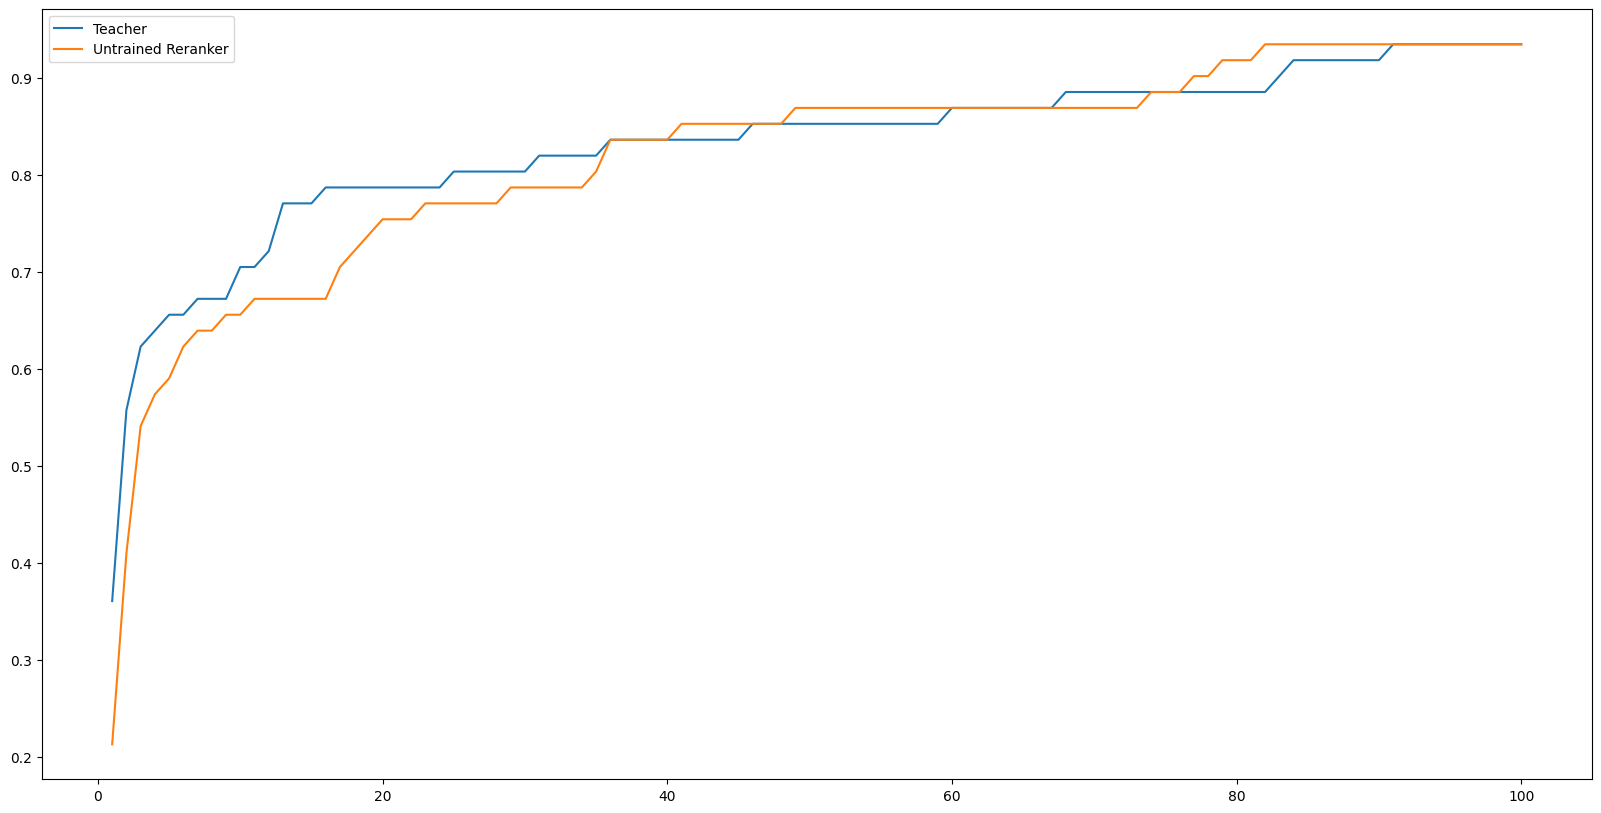

In [38]:
d_rerank = teacher_model.evaluate(df_dev_rr, task_name, lang, ls_k=ls_k, output_folder="tmp/rerank")
df_rerank_metrics = pd.DataFrame(d_rerank["monolingual"])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20, 10))
df_metrics.iloc[:100].plot(ax=ax)
df_rerank_metrics.iloc[:100].plot(ax=ax)
plt.legend(["Teacher", "Untrained Reranker"])

In [39]:
rerank_model.save("tmp/reranker")

In [ ]:
from transformers.models.xlm_roberta.configuration_xlm_roberta import XLMRobertaConfig
from transformers import AutoModel
# from jinaai.jina_reranker_v2_base_multilingual.configuration_xlm_roberta import XLMRobertaFlashConfig
# configuration_xlm_roberta.XLMRobertaFlashConfig
config = XLMRobertaConfig.from_pretrained("tmp/reranker", trust_remote_code=True)
model = AutoModel.from_pretrained("tmp/reranker", trust_remote_code=True, config=config)

ModuleNotFoundError: No module named 'jinaai.jina_reranker_v2_base_multilingual'